# Schools!



In [ ]:
We chose Public Schools as one of the relevant datasets because schools and literacy rates generally reflect positively in a community. Additionally, they provide services that address basic needs for the community such as nutrition, healthcare and mental health support and therefore can be considered as a social service


To begin, I loaded the dataset containing the locations and details of public schools in Allegheny County. This dataset includes latitude and longitude coordinates for each school, which allows for spatial analysis using mapping tools like GeoPandas and Shapely. To load the dataset correctly, it was important to get the exact name that is specified in the directory and it took a while to correctly load the dataset. The tools like GeoPandas and Shapely needed to be imported into the notebook.


In [2]:
import sys
sys.path.append("/ihome/cmpinf0010_2025s/kkr33/.local/lib/python3.11/site-packages")

One of the key technical steps in this project was making sure the school coordinates (latitude and longitude) matched the format of the Pittsburgh neighborhood shapefile. The shapefile originally used a projection called EPSG:2272, which is based on feet and specific to Pennsylvania. However, the school dataset uses standard geographic coordinates (EPSG:4326), which are in degrees. In order to accurately check which neighborhood each school falls into, I had to reproject the neighborhood shapefile to EPSG:4326 so that both datasets were using the same coordinate system. Without this conversion, spatial matching wouldn't work, and schools wouldn’t be correctly assigned to neighborhoods.


In [3]:
import pandas as pd
import fpsnippets
from shapely.geometry import Point
import geopandas
schools_df = pd.read_csv('Allegheny_County_Public_Schools___Local_Education_Agency_(LEAs)_Locations.csv')

NEIGHBORHOODS = geopandas.read_file(
    "https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/c5a93a8e-03d7-4eb3-91a8-c6b7db0fa261/download/pittsburghpaneighborhoods-.zip"
)
NEIGHBORHOODS = NEIGHBORHOODS.to_crs(epsg=4326)

This block of code defines a function called `geo_to_neighborhood`, which takes a latitude and longitude point and checks which Pittsburgh neighborhood it falls into using spatial geometry. It loops through each neighborhood in the shapefile and uses the `contains` method to see if the point is inside the neighborhood boundary. Once it finds a match, it returns the neighborhood name.

After defining the function, I applied it to every row in the school dataset using the latitude (`Y`) and longitude (`X`) columns. This created a new column called `"Neighborhood"` in the DataFrame. Finally, I used `value_counts()` to count how many schools were located in each neighborhood, and stored those results in a new DataFrame for visualization and analysis.


In [6]:
def geo_to_neighborhood(latitude, longitude):
    pt = Point(longitude, latitude)
    for _idx, neighborhood in NEIGHBORHOODS.iterrows():
        if neighborhood["geometry"].contains(pt):
            return neighborhood["hood"]
    return None
schools_df["Neighborhood"] = schools_df.apply(
lambda row: geo_to_neighborhood(row["Y"], row["X"]),
axis=1
)
school_counts = schools_df["Neighborhood"].value_counts().reset_index()
school_counts.columns = ["Neighborhood", "School Count"]


Here I tested if the function was mapping coordinates correctly, and it did!

In [30]:
geo_to_neighborhood(40.440624, -79.995888)

'Central Business District'

# Visualization of public schools in each Pittsburgh neighborhood


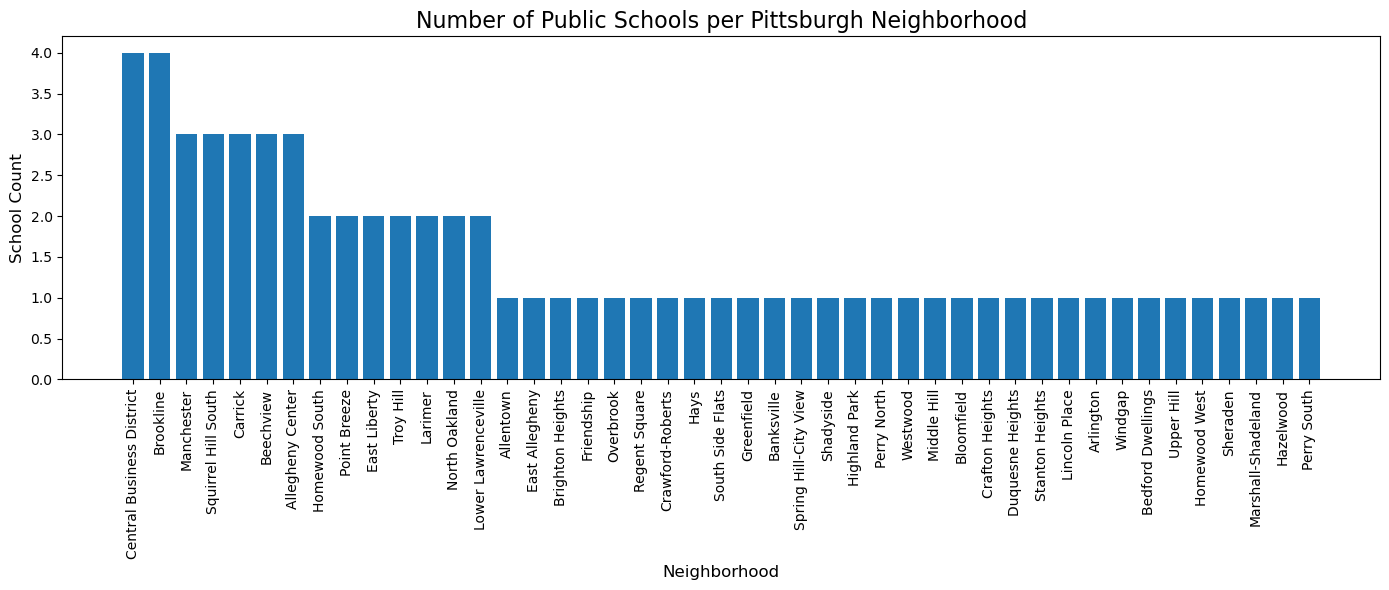

In [7]:
import matplotlib.pyplot as plt

school_counts_sorted = school_counts.sort_values(by="School Count", ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(school_counts_sorted["Neighborhood"], school_counts_sorted["School Count"])
plt.title("Number of Public Schools per Pittsburgh Neighborhood", fontsize=16)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("School Count", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualization of the top 10 neighborhoods with the most public schools


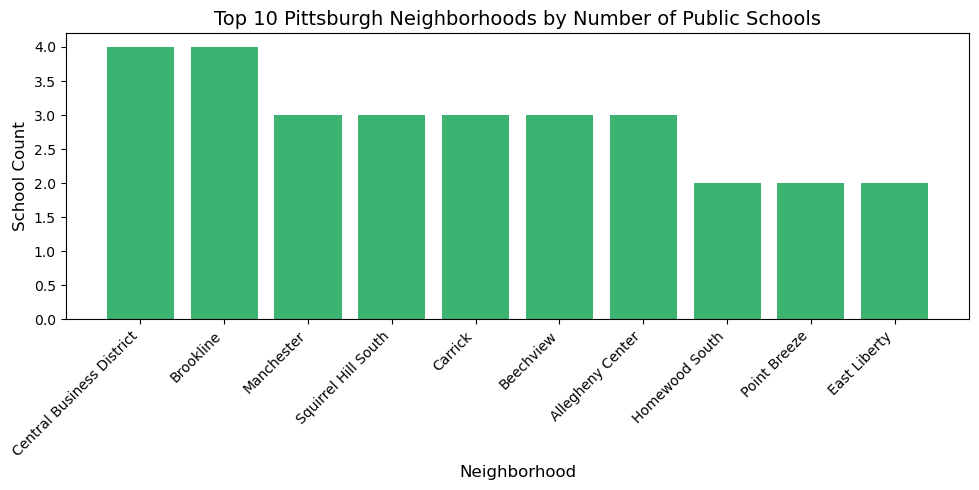

In [9]:
import matplotlib.pyplot as plt

top10 = school_counts.sort_values(by="School Count", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.bar(top10["Neighborhood"], top10["School Count"], color="mediumseagreen")
plt.title("Top 10 Pittsburgh Neighborhoods by Number of Public Schools", fontsize=14)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("School Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Tabular representation of the number of public schools in each Pittsburgh neighborhood


In [10]:
school_table = school_counts.sort_values(by="School Count", ascending=False).reset_index(drop=True)

import pandas as pd
from IPython.display import display

display(school_table)

,Neighborhood,School Count
0,Central Business District,4
1,Brookline,4
2,Manchester,3
3,Squirrel Hill South,3
4,Carrick,3
5,Beechview,3
6,Allegheny Center,3
7,Homewood South,2
8,Point Breeze,2
9,East Liberty,2


Initially, we were going to add the counts for each submetric to determine the best neighborhood in Pittsburgh. However, we realized that this does not account for the size of the neighborhood. It is possible that a neighborhood could support a large population and have a single school, while a smaller neighborhood has a single school as well. While the count is the same, the access to the resource varies - the larger neighborhood is less ideal because there is a single school for a larger population. In order to account for this, we decided to assign a score by dividing the count of services per neighborhood by its population and we normalized the score using a z-distribution so that we could make a fairer comparison.

           Neighborhood  Normalized Score
21                 Hays         98.833940
6      Allegheny Center         93.700769
40        Homewood West         84.970674
2            Manchester         83.094343
11              Larimer         78.158348
19        Regent Square         69.315884
7        Homewood South         63.715631
13  Lower Lawrenceville         58.446494
10            Troy Hill         58.398139
37              Windgap         57.886444


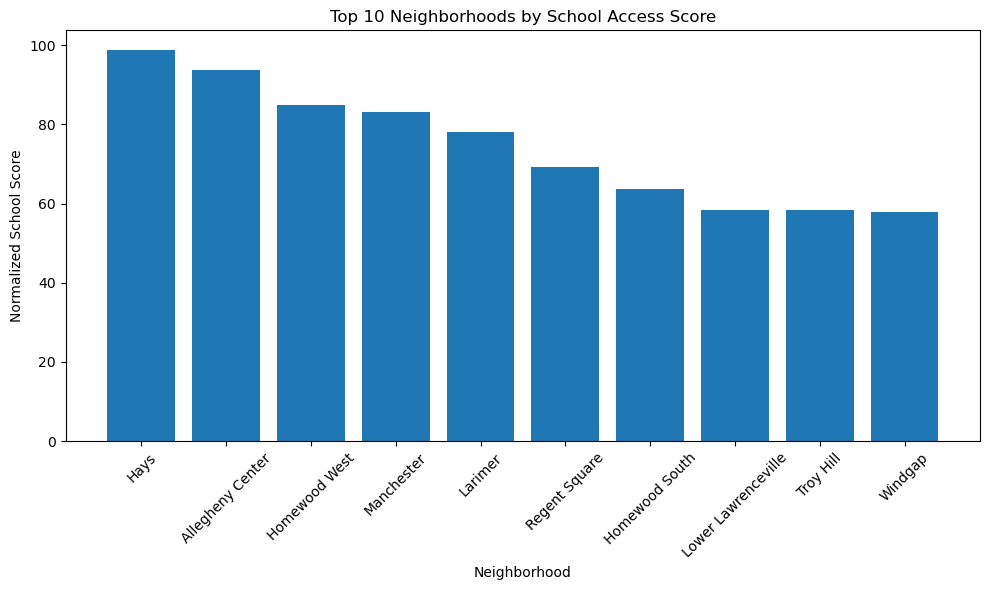

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


population_df = pd.read_csv(
    "https://data.wprdc.org/dataset/95af9f2c-61c8-446b-ae72-852e195684f3/resource/a8414ed5-c50f-417e-bb67-82b734660da6/download/preliminarycitypittsburghneighborhood_pl94171summary-2.csv"
)
population_df = population_df[["Neighborhood", "2020_Total_Population"]]
population_df["2020_Total_Population"] = pd.to_numeric(population_df["2020_Total_Population"], errors="coerce")

def clean_neighborhood_name(name):
    name = re.split(r'[-()]', name)[0]
    return name.strip()
merged_df = school_counts.copy()


population_df["Neighborhood"] = population_df["Neighborhood"].apply(clean_neighborhood_name)
merged_df["Neighborhood"] = merged_df["Neighborhood"].apply(clean_neighborhood_name)

merged_df = merged_df.merge(population_df, on="Neighborhood", how="left")

merged_df["Raw Score"] = merged_df["School Count"] / merged_df["2020_Total_Population"]

mean = merged_df["Raw Score"].mean()
std = merged_df["Raw Score"].std()
merged_df["z_score"] = (merged_df["Raw Score"] - mean) / std

merged_df["Normalized Score"] = 100 / (1 + np.exp(-merged_df["z_score"]))

top10 = merged_df.sort_values("Normalized Score", ascending=False)[["Neighborhood", "Normalized Score"]].head(10)
print(top10)

plt.figure(figsize=(10, 6))
plt.bar(top10["Neighborhood"], top10["Normalized Score"])
plt.title("Top 10 Neighborhoods by School Access Score")
plt.xlabel("Neighborhood")
plt.ylabel("Normalized School Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


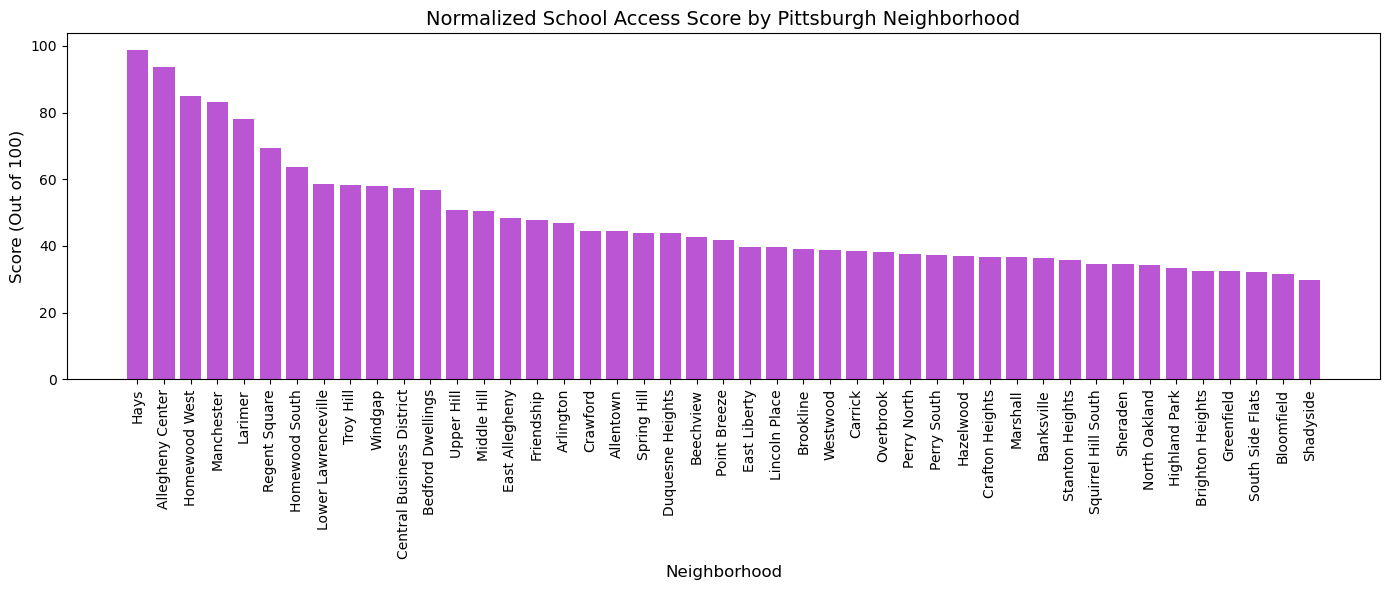

In [15]:
import matplotlib.pyplot as plt
final_table = merged_df.sort_values(by="Normalized Score", ascending=False).reset_index(drop=True)

plot_data = final_table.sort_values(by="Normalized Score", ascending=False)
plt.figure(figsize=(14, 6))
plt.bar(plot_data["Neighborhood"], plot_data["Normalized Score"], color="mediumorchid")
plt.title("Normalized School Access Score by Pittsburgh Neighborhood", fontsize=14)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("Score (Out of 100)", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

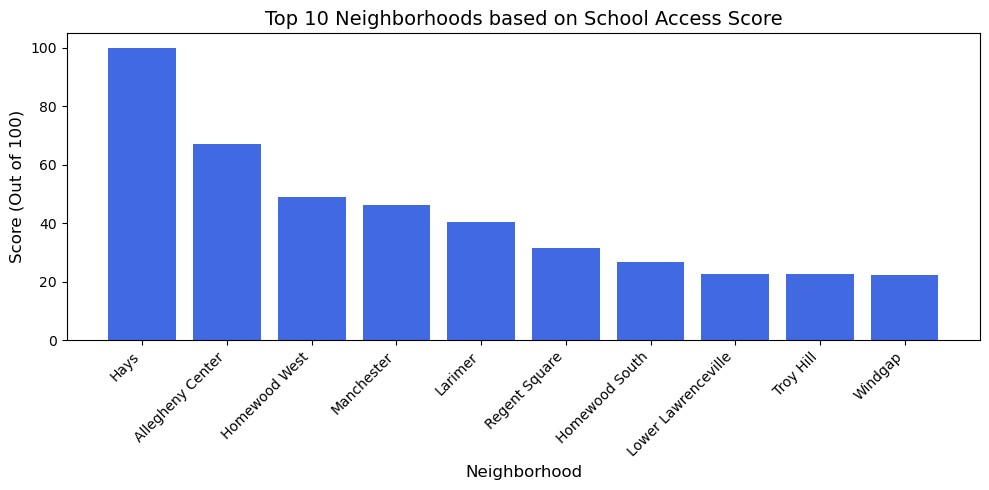

In [29]:

top10 = final_table.head(10)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(top10["Neighborhood"], top10["Normalized Score"], color="royalblue")
plt.title("Top 10 Neighborhoods based on School Access Score", fontsize=14)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("Score (Out of 100)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Conclusion



Based on the combined scores, the top 3 neighborhoods are East Liberty, South Shore and Central Business District. My favorite neighborhood is Shadyside, which is not in anywhere in the top 10. I am not a Pittsburgh native so I do not know much about the place and I am not familiar with any of the places mentioned in the top 3. I think a possible reason that I did not see Shadyside as a runner up is because what I like about it is the shops and restaurants around the area. Our data driven argument does not focus on this so it makes sense. With an investigation focused on restaurants and shops, I think Shadyside would be somewhere at the top. 

Based on the schools dataset, we can see that access to schools is not evenly distributed across Pittsburgh neighborhoods. By calculating the number of schools per capita and normalizing using z-scores, we identified the top neighborhoods that offer better access to educational resources relative to their population size. These areas may reflect more developed infrastructure or planning around education. On the other hand, neighborhoods with lower scores might benefit from more targeted investment in schooling facilities to support growing or underserved populations. This analysis helps highlight where school access is strong and where improvements could have the greatest impact. It is also important to consider the age groups in these neighborhoods. With a majority of people in an older age group, it would not be necessary for a neighborhood to have many schools and this is an additional factor that could be considered if we were to carry this investigation forward.